# Experiment 3 - Open Food Facts - Data quality measurement using Autoencoder

**Outline:**

1. [Import common libraries](#Import-common-libraries)
1. [Test GPU](#Test-GPU)
1. [Basic data exploration](#Basic-data-exploration)
1. [Text encoding methods](#Text-encoding-methods)
1. [Prepare Autoencoder model](#Prepare-Autoencoder-model)
    1. [Evaluate autoencoder model performance](#Evaluate-autoencoder-model-performance)
1. [Data preparation for processing results](#Data-preparation-for-processing-results)
1. [Evaluate DQ measurement performance](#Evaluate-DQ-measurement-performance)
1. [Evaluate success of the autoencoder model on synthetic errors](#Evaluate-success-of-the-autoencoder-model-on-synthetic-errors)
1. [Examining the results](#Examining-the-results)

Details of the experiment can be found in the Master's thesis in sections:
* 3.3.1 Experiment 1 - Autoencoder,
* 3.3.1.2 Autoencoder experiment and results – Open Food Facts dataset.

## Import common libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Test GPU

In [2]:
print(tf.test.gpu_device_name())

/device:GPU:0


## Basic data exploration

In [3]:
data = pd.read_csv('./../data/open-food-facts-experimental-synthetic-dq-issues.tsv', sep='\t')

/home/mmikus/miniconda3/envs/experiments-measuring-dq/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (46,129,174,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Convert columns to string 
for col in data.columns:
    data[col] = data[col].astype('str')

In [5]:
data.head()

dq_issue_index orig_data_index           code  \
0              0          157939    70690272964   
1              1          567345  3222472861799   
2              2         1273255  8437008732015   
3              3          786869  3700153131503   
4              4         1299936  8690799020574   

                                                 url          creator  \
0  http://world-en.openfoodfacts.org/product/0070...  usda-ndb-import   
1  http://world-en.openfoodfacts.org/product/3222...  date-limite-app   
2  http://world-en.openfoodfacts.org/product/8437...             ewen   
3  http://world-en.openfoodfacts.org/product/3700...          kiliweb   
4  http://world-en.openfoodfacts.org/product/8690...          kiliweb   

    created_t      created_datetime last_modified_t last_modified_datetime  \
0  1489138050  2017-03-10T09:27:30Z      1587630404   2020-04-23T08:26:44Z   
1  1426782696  2015-03-19T16:31:36Z      1574431290   2019-11-22T14:01:30Z   
2  1538672781  2018-10-04T17:06:21Z      1574804868   2019-11-26T21:47:48Z   
3  1515873697  2018-01-13T20:01:37Z      1515873700   2018-01-13T20:01:40Z   
4  1526133173  2018-05-12T13:52:53Z      1552074680   2019-03-08T19:51:20Z   

                                  product_name  \
0                                      Peanuts   
1              Compote allégée Pommes Abricots   
2                                   Platanitos   
3  Overstim S - Nutrition - Energix Bio Citron   
4                                        Tahin   

                                        generic_name   quantity  \
0                                                nan        nan   
1  Compote de pommes et d'abricots allégée en suc...  4 x 100 g   
2                                                nan       85 g   
3                                                nan        nan   
4                                                nan        nan   

              packaging        packaging_tags  \
0                   nan                   nan   
1  pot,plastique,carton  pot,plastique,carton   
2                 bolsa                 bolsa   
3                   nan                   nan   
4                   nan                   nan   

                                    brands                       brands_tags  \
0  Fisher,  John B. Sanfilippo & Son  Inc.  fisher,john-b-sanfilippo-son-inc   
1                                   Casino                            casino   
2                            El Venezolano                     el-venezolano   
3                               Overstim.s                        overstim-s   
4                                    Metin                             metin   

                                          categories  \
0                                             Snacks   
1  Aliments et boissons à base de végétaux, Alime...   
2                            Botanas, Snacks salados   
3                                                nan   
4  Aliments et boissons à base de végétaux, Alime...   

                                     categories_tags  \
0                                          en:snacks   
1  en:plant-based-foods-and-beverages,en:plant-ba...   
2                          en:snacks,en:salty-snacks   
3                                                nan   
4  en:plant-based-foods-and-beverages,en:plant-ba...   

                                       categories_en origins origins_tags  \
0                                             Snacks     nan          nan   
1  Plant-based foods and beverages,Plant-based fo...     nan          nan   
2                                Snacks,Salty snacks     nan          nan   
3                                                nan     nan          nan   
4  Plant-based foods and beverages,Plant-based fo...     nan          nan   

  manufacturing_places manufacturing_places_tags  \
0                  nan                       nan   
1                  nan                       nan   
2             

In [6]:
display(data.shape)
display(data.describe())
data.info()

(339072, 187)

dq_issue_index orig_data_index         code  \
count          339072          339072       339072   
unique         339072          339072       339027   
top            303543          949493  75925301099   
freq                1               1            2   

                                                      url  creator  \
count                                              339072   339072   
unique                                             339066     4963   
top     http://world-en.openfoodfacts.org/product/6194...  kiliweb   
freq                                                    2   171696   

         created_t      created_datetime last_modified_t  \
count       339072                339072          339072   
unique      309114                309116          293655   
top     1587662527  2020-04-23T17:22:07Z      1552770887   
freq            11                    11              22   

       last_modified_datetime product_name generic_name quantity packaging  \
count                  339072       339072       339072   339072    339072   
unique                 293655       253144        21381    11421     12989   
top      2019-03-16T21:14:47Z          nan          nan      nan       nan   
freq                       22        14738       313801   243643    285686   

       packaging_tags  brands brands_tags categories categories_tags  \
count          339072  339072      339072     339072          339072   
unique          10732   52756       44438      35062           21173   
top               nan     nan         nan        nan             nan   
freq           285686  148989      149004     161677          161678   

       categories_en origins origins_tags manufacturing_places  \
count         339072  339072       339072               339072   
unique         21173    3445         3096                 7065   
top              nan     nan          nan                  nan   
freq          161678  324334       324363               315597   

       manufacturing_places_tags  labels labels_tags labels_en emb_codes  \
count                     339072  339072      339072    339072    339072   
unique                      6589   19085       14539     14539      9882   
top                          nan     nan         nan       nan       nan   
freq                      315606  259152      259148    259148    316385   

       emb_codes_tags first_packaging_code_geo  cities cities_tags  \
count          339072                   339072  339072      339072   
unique           9157                     2039       1        3258   
top               nan                      nan     nan         nan   
freq           316395                   324066  339072      322895   

       purchase_places  stores countries countries_tags countries_en  \
count           339072  339072    339072         339072       339072   
unique            3792    4385      3669           1310         1310   
top                nan     nan    France      en:france       France   
freq            306202  289580    104684         152713       152713   

       ingredients_text allergens allergens_en  traces traces_tags traces_en  \
count            339072    339072       339072  339072      339072    339072   
unique           139549      2026            1    3157        3336      3336   
top                 nan       nan          nan     nan         nan       nan   
freq             184178    299045       339072  320390      315233    315233   

       serving_size serving_quantity no_nutriments additives_n additives  \
count        339072           339072        339072      339072    339072   
unique        18928             1229             1          32        10   
top             nan              nan           nan         nan       nan   
freq         231229           231174        339072      184178    339063   

       additives_tags additives_en ingredients_from_palm_oil_n  \
count          339072       339072                      3390

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339072 entries, 0 to 339071
Columns: 187 entries, dq_issue_index to synthetic_dq_issue_columns
dtypes: object(187)
memory usage: 483.8+ MB


## Text encoding methods

In [7]:
def utf16_token_to_int(token):
    # encode column value as big-endian utf-16 
    # used fixed width encoding scheme and always uses 4 bytes to encode a Unicode code point (a numeric value)
    encoded_token = token.encode('utf-16-be')

    # convert 2 bytes to an integer
    chunk_size = 2
    ints = []
    for i in range(0, len(encoded_token), chunk_size):
        chunk = encoded_token[i:i+chunk_size]
        ints.append(int.from_bytes(chunk, 'big'))

    return ints

In [8]:
from keras.preprocessing.text import text_to_word_sequence

def column_value_to_tokenized_sequence(column_value):
    tokens = text_to_word_sequence(column_value, filters='-/\\_:~\t\n', lower=False) 

    tokenized_sequences = []
    for token in tokens:
        tokenized_sequence = utf16_token_to_int(token)
        tokenized_sequences.extend(tokenized_sequence)
        tokenized_sequences.extend([0])
        
    return tokenized_sequences

Using TensorFlow backend.


In [9]:
from keras.preprocessing.sequence import pad_sequences

# Pads sequences to the same length.
def encode_to_pad_sequences(column_values):
    encoded_sequences = []
    for column_value in column_values:
        encoded_sequence = column_value_to_tokenized_sequence(column_value)
        encoded_sequences.append(encoded_sequence)

    return pad_sequences(encoded_sequences, padding='post')

In [10]:
encode_to_pad_sequences(["Hi Pieter", "Hi Tomas", "Hi Michael", "$0.5", "$0,5", "This is really long text for testing.", "http://www1.macys.com/shop/product/b.temptd-by-wacoal-lace-kiss-thong-3-pack-976282?ID=2687057&amp;CategoryID=65739"])

array([[ 72, 105,   0,  80, 105, 101, 116, 101, 114,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 72, 105,   0,  84, 111, 109,  97, 115,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Prepare Autoencoder model

In [11]:
method_threshold = 0.9999

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [13]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Lambda, Layer
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K
from keras import metrics

### AE model

In [14]:
def create_ae_model(input_dim, enc_dim):
  
    latent_dim = 4
    
    if latent_dim >= enc_dim:
        latent_dim = 2
    
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(enc_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
    encoder = Dense(latent_dim, activation="relu")(encoder)
    decoder = Dense(enc_dim, activation='relu')(encoder)
    decoder = Dense(input_dim, activation='tanh')(decoder)

    return Model(inputs=input_layer, outputs=decoder)

In [15]:
core_cols = data.columns[2:-4].tolist() # Foods

In [16]:
print(core_cols)

['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags', 'ingredients_that_may_be_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score', 'nutriscore_grade', '

In [17]:
core_cols_count = len(core_cols)
print(core_cols_count)

181


In [18]:
# Create data quality MSE info columns
dq_col_names = []
for col in core_cols:
    dq_col_names.append("{}_mse".format(col))
    dq_col_names.append("is_{}_mse_outlier".format(col))

In [19]:
print(dq_col_names)

['code_mse', 'is_code_mse_outlier', 'url_mse', 'is_url_mse_outlier', 'creator_mse', 'is_creator_mse_outlier', 'created_t_mse', 'is_created_t_mse_outlier', 'created_datetime_mse', 'is_created_datetime_mse_outlier', 'last_modified_t_mse', 'is_last_modified_t_mse_outlier', 'last_modified_datetime_mse', 'is_last_modified_datetime_mse_outlier', 'product_name_mse', 'is_product_name_mse_outlier', 'generic_name_mse', 'is_generic_name_mse_outlier', 'quantity_mse', 'is_quantity_mse_outlier', 'packaging_mse', 'is_packaging_mse_outlier', 'packaging_tags_mse', 'is_packaging_tags_mse_outlier', 'brands_mse', 'is_brands_mse_outlier', 'brands_tags_mse', 'is_brands_tags_mse_outlier', 'categories_mse', 'is_categories_mse_outlier', 'categories_tags_mse', 'is_categories_tags_mse_outlier', 'categories_en_mse', 'is_categories_en_mse_outlier', 'origins_mse', 'is_origins_mse_outlier', 'origins_tags_mse', 'is_origins_tags_mse_outlier', 'manufacturing_places_mse', 'is_manufacturing_places_mse_outlier', 'manufact

In [20]:
import math
def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

In [21]:
data_quality_mse_df = pd.DataFrame(columns = dq_col_names)
outlier_cols = "outlier_columns"
data_quality_mse_df[outlier_cols] = ''

fit_histories = []
mse_threshold_colums = {}

i = 0
for col in core_cols:
    i = i+1
    print("########### '{}' - {}/{} #############".format(col, i, core_cols_count))

    column_values = data[col].tolist()
    column_values_df = pd.DataFrame(column_values)

    encoded_column_values = encode_to_pad_sequences(column_values)

    scaler = MinMaxScaler()
    scaled_encoded_column_values = scaler.fit_transform(encoded_column_values)

    X_train, X_test = train_test_split(scaled_encoded_column_values, test_size=0.25, random_state=570)

    enc_dimension = 0
    if 8 >= X_train.shape[1]:
        enc_dimension = 4
    else:
        enc_dimension = int(X_train.shape[1] / 2)
        enc_dimension = round_up_to_even(enc_dimension)
    

    autoencoder_model = create_ae_model(X_train.shape[1], enc_dimension)
    autoencoder_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy']) 
    autoencoder_model.summary()
    
    ## Fit model 
    epoch_count = 30
    batch_size = 256
    fit_history = autoencoder_model.fit(X_train, X_train, epochs=epoch_count, batch_size=batch_size, shuffle=True, validation_data=(X_test, X_test), verbose=1).history

    fit_histories.append(fit_history)

    # Predict
    predicted_data = autoencoder_model.predict(scaled_encoded_column_values)

    # Get MSE
    mse = np.mean(np.power(scaled_encoded_column_values - predicted_data, 2), axis=1)

    # Save MSE to DQ MSE dataframe
    dq_mse_column = "{}_mse".format(col)
    data_quality_mse_df[dq_mse_column] = mse

    # Find MSE treshold for outlier detection
    mse_threshold = np.quantile(data_quality_mse_df[dq_mse_column], method_threshold)
    mse_threshold_colums[dq_mse_column] = mse_threshold

    # Replace all NaN in 'outlier_columns' column
    if i == 1:
        data_quality_mse_df[outlier_cols].replace(np.nan, '', inplace=True)
    
    # Save outliers info to DQ MSE dataframe
    dq_mse_outlier_column = "is_{}_mse_outlier".format(col)
    data_quality_mse_df[dq_mse_outlier_column] = 0
    data_quality_mse_df.loc[data_quality_mse_df[dq_mse_column] > mse_threshold, dq_mse_outlier_column] = 1
    data_quality_mse_df.loc[data_quality_mse_df[dq_mse_column] > mse_threshold, outlier_cols] = data_quality_mse_df.loc[data_quality_mse_df[dq_mse_column] > mse_threshold, outlier_cols].astype(str) + "'{}',".format(col)

########### 'code' - 1/181 #############
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 124       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                150       
_________________________________________________________________
dense_4 (Dense)              (None, 60)                1860      
Total params: 3,964
Trainable params: 3,964
Non-trainable params: 0
_________________________________________________________________
Train on 254304 samples, validate on 84768 samples
Epoch 1/30
254304/254304 [======================

### Evaluate autoencoder model performance

In [22]:
# Save results
df_fit_histories = pd.DataFrame(fit_histories, index=pd.Index(core_cols, name="column_name")) 
file_name = "experiment-1-autoencoder-foods-loss-columns"
df_fit_histories.to_csv(f'./images/autoencoder/{file_name}.tsv', sep='\t')

91


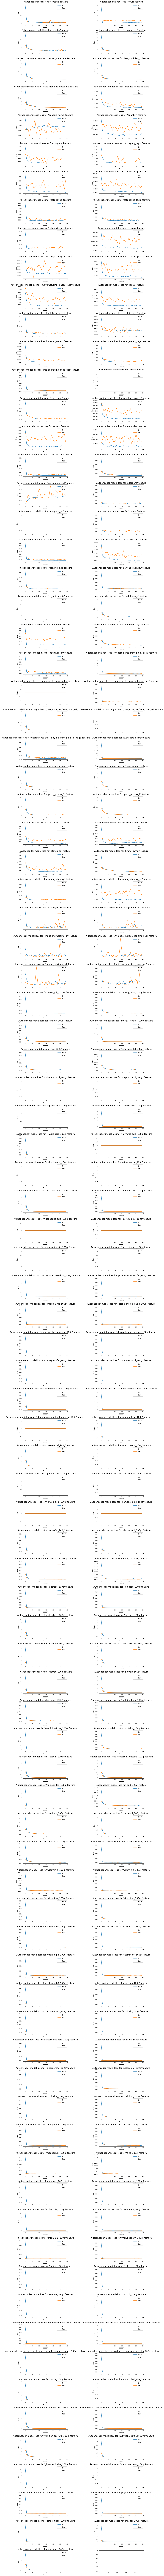

In [23]:
rows_per_column = int(core_cols_count/2) + 1
print(rows_per_column)
fig, axs = plt.subplots(rows_per_column, 2)
i = 0
y = 0
index = 0
for column_name in core_cols:
    axs[i, y].plot(fit_histories[index]['loss'])
    #axs[i, y].plot(fit_histories[index]['loss'])
    axs[i, y].plot(fit_histories[index]['val_loss'])
    axs[i, y].set_title("Autoencoder model loss for '{}' feature".format(column_name), fontsize=18)
    axs[i, y].set_ylabel('loss', fontsize=14)
    axs[i, y].set_xlabel('epoch', fontsize=14)
    axs[i, y].legend(['train', 'test'], loc='upper right', fontsize=14);
      
    # Index process
    y = y + 1    
    if y == 2:
        y = 0
        i = i + 1
    
    if i == rows_per_column:
        i = 0
        
    index = index + 1
        
fig.set_size_inches(18, 300)
fig.tight_layout()
#plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-loss-columns.pdf', bbox_inches='tight')
plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-loss-columns.png', bbox_inches='tight')

#### Evaluate autoencoder for the first column

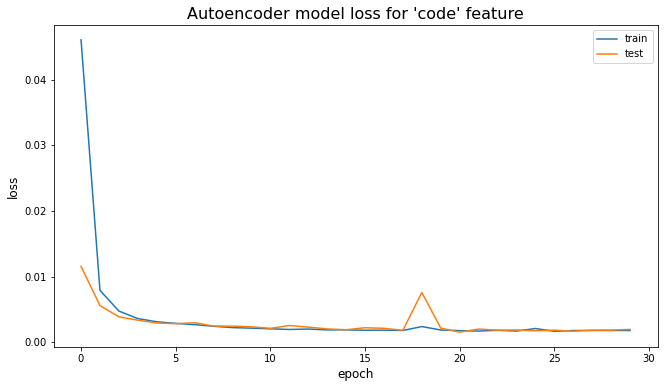

In [38]:
fig, ax = plt.subplots()
colmn_name = core_cols[0]
ax.plot(fit_histories[0]['loss'])
ax.plot(fit_histories[0]['val_loss'])
ax.set_title("Autoencoder model loss for '{}' feature".format(colmn_name), fontsize=16)
ax.set_ylabel('loss', fontsize=12)
ax.set_xlabel('epoch', fontsize=12)
ax.legend(['train', 'test'], loc='upper right', fontsize=10);

fig.tight_layout()
fig.set_size_inches(10, 6)
#plt.show()
plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-loss-{colmn_name}.pdf', bbox_inches='tight')

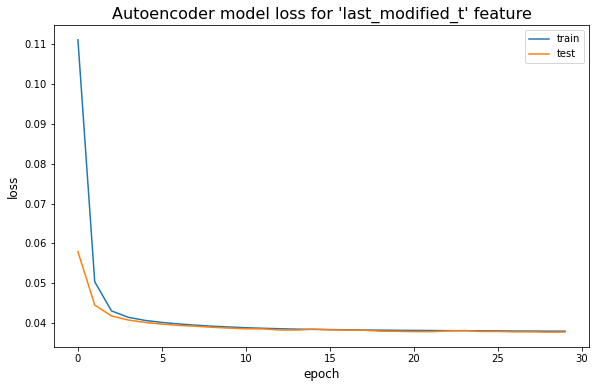

In [188]:
fig, ax = plt.subplots()
id_col = 5
colmn_name = core_cols[id_col]
ax.plot(fit_histories[id_col]['loss'])
ax.plot(fit_histories[id_col]['val_loss'])
ax.set_title("Autoencoder model loss for '{}' feature".format(colmn_name), fontsize=16)
ax.set_ylabel('loss', fontsize=12)
ax.set_xlabel('epoch', fontsize=12)
ax.legend(['train', 'test'], loc='upper right', fontsize=10);

fig.tight_layout()
fig.set_size_inches(10, 6)
#plt.show()
plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-loss-{colmn_name}.pdf', bbox_inches='tight')

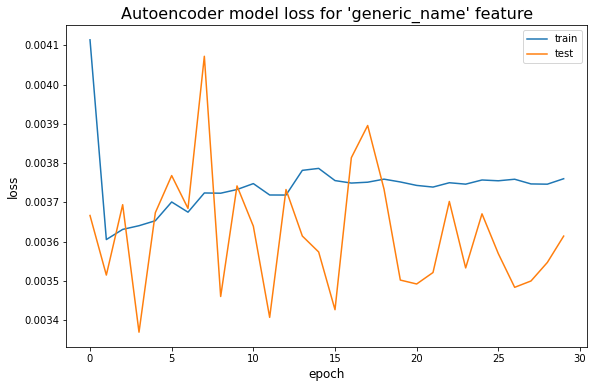

In [39]:
fig, ax = plt.subplots()
id_col = 8
colmn_name = core_cols[id_col]
ax.plot(fit_histories[id_col]['loss'])
ax.plot(fit_histories[id_col]['val_loss'])
ax.set_title("Autoencoder model loss for '{}' feature".format(colmn_name), fontsize=16)
ax.set_ylabel('loss', fontsize=12)
ax.set_xlabel('epoch', fontsize=12)
ax.legend(['train', 'test'], loc='upper right', fontsize=10);

fig.tight_layout()
fig.set_size_inches(10, 6)
#plt.show()
plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-loss-{colmn_name}.pdf', bbox_inches='tight')

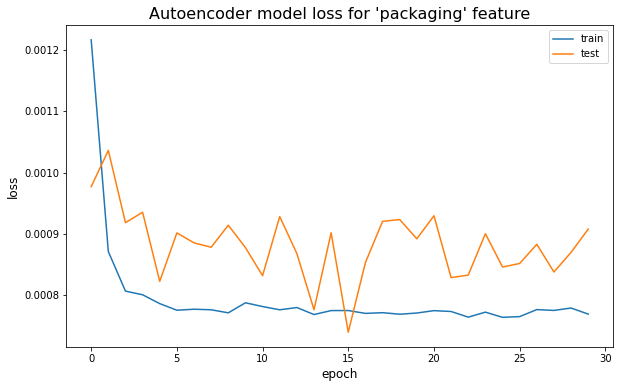

In [40]:
fig, ax = plt.subplots()
id_col = 10
colmn_name = core_cols[id_col]
ax.plot(fit_histories[id_col]['loss'])
ax.plot(fit_histories[id_col]['val_loss'])
ax.set_title("Autoencoder model loss for '{}' feature".format(colmn_name), fontsize=16)
ax.set_ylabel('loss', fontsize=12)
ax.set_xlabel('epoch', fontsize=12)
ax.legend(['train', 'test'], loc='upper right', fontsize=10);

fig.tight_layout()
fig.set_size_inches(10, 6)
#plt.show()
plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-loss-{colmn_name}.pdf', bbox_inches='tight')

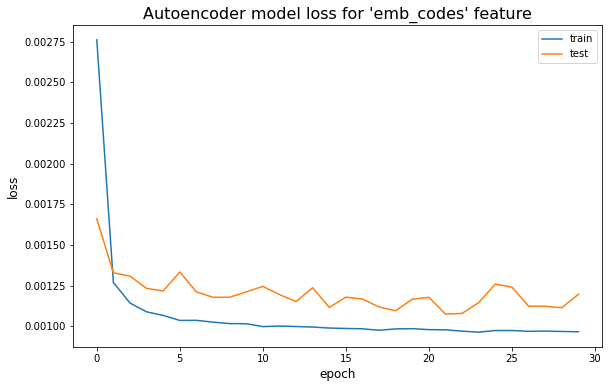

In [41]:
fig, ax = plt.subplots()
id_col = 24
colmn_name = core_cols[id_col]
ax.plot(fit_histories[id_col]['loss'])
ax.plot(fit_histories[id_col]['val_loss'])
ax.set_title("Autoencoder model loss for '{}' feature".format(colmn_name), fontsize=16)
ax.set_ylabel('loss', fontsize=12)
ax.set_xlabel('epoch', fontsize=12)
ax.legend(['train', 'test'], loc='upper right', fontsize=10);

fig.tight_layout()
fig.set_size_inches(10, 6)
#plt.show()
plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-loss-{colmn_name}.pdf', bbox_inches='tight')

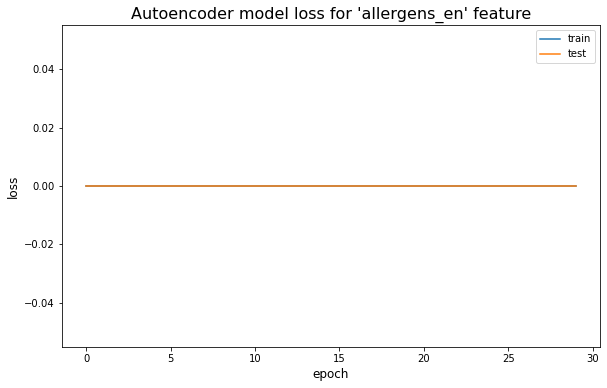

In [42]:
fig, ax = plt.subplots()
id_col = 36
colmn_name = core_cols[id_col]
ax.plot(fit_histories[id_col]['loss'])
ax.plot(fit_histories[id_col]['val_loss'])
ax.set_title("Autoencoder model loss for '{}' feature".format(colmn_name), fontsize=16)
ax.set_ylabel('loss', fontsize=12)
ax.set_xlabel('epoch', fontsize=12)
ax.legend(['train', 'test'], loc='upper right', fontsize=10);

fig.tight_layout()
fig.set_size_inches(10, 6)
#plt.show()
plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-loss-{colmn_name}.pdf', bbox_inches='tight')

## Data preparation for processing results

In [29]:
data_quality_mse_df["sum_mse"] = 0
data_quality_mse_df["sum_mse_outlier"] = 0
# Sum outlier and mse
for col in core_cols:
    data_quality_mse_df["sum_mse"] += data_quality_mse_df["{}_mse".format(col)]
    data_quality_mse_df["sum_mse_outlier"] += data_quality_mse_df["is_{}_mse_outlier".format(col)]

In [30]:
print(data_quality_mse_df.shape)
print(data.shape)

(339072, 365)
(339072, 187)


In [31]:
data_quality_mse_df.head()

code_mse  is_code_mse_outlier   url_mse  is_url_mse_outlier  creator_mse  \
0  0.000500                    0  0.001318                   0     0.000020   
1  0.000419                    0  0.004380                   0     0.000158   
2  0.000734                    0  0.003440                   0     0.002768   
3  0.000476                    0  0.005233                   0     0.000009   
4  0.000815                    0  0.000993                   0     0.000009   

   is_creator_mse_outlier  created_t_mse  is_created_t_mse_outlier  \
0                       0       0.040425                         0   
1                       0       0.064928                         0   
2                       0       0.062412                         0   
3                       0       0.041203                         0   
4                       0       0.053537                         0   

   created_datetime_mse  is_created_datetime_mse_outlier  last_modified_t_mse  \
0              0.022455                                0             0.032292   
1              0.014960                                0             0.027251   
2              0.028228                                0             0.026030   
3              0.026999                                0             0.071759   
4              0.030024                                0             0.062745   

   is_last_modified_t_mse_outlier  last_modified_datetime_mse  \
0                               0                    0.003042   
1                               0                    0.021327   
2                               0                    0.014676   
3                               0                    0.031700   
4                               0                    0.044020   

   is_last_modified_datetime_mse_outlier  product_name_mse  \
0                                      0          0.000002   
1                                      0          0.000002   
2                                      0          0.000002   
3                                      0          0.000002   
4                                      0          0.000002   

   is_product_name_mse_outlier  generic_name_mse  is_generic_name_mse_outlier  \
0                            0      2.662341e-07                            0   
1                            0      2.059147e-04                            0   
2                            0      2.662341e-07                            0   
3                            0      2.662341e-07                            0   
4                            0      2.662341e-07                            0   

   quantity_mse  is_quantity_mse_outlier  packaging_mse  \
0  6.590929e-07                        0   4.721345e-08   
1  1.638040e-06                        0   3.698521e-06   
2  7.970795e-07                        0   9.768614e-08   
3  6.590929e-07                        0   4.721345e-08   
4  6.590929e-07                        0   4.721345e-08   

   is_packaging_mse_outlier  packaging_tags_mse  \
0                         0        4.047686e-07   
1                         0        3.972459e-06   
2                         0        4.314205e-07   
3                         0        4.047686e-07   
4                         0        4.047686e-07   

   is_packaging_tags_mse_outlier    brands_mse  is_brands_mse_outlier  \
0                              0  1.812994e-05                      0   
1                              0  4.608128e-07                      0   
2                              0  5.601539e-07                      0   
3                              0  4.575083e-07                      0   
4                              0  4.717879e-07                      0   

   brands_tags_mse  is_brands_tags_mse_outlier  categories_mse  \
0     2.871377e-05                           0        0.000001   
1     1.961145e-07                           0        0.000224   
2     3.033754e-07                           0        0.000004   
3   

In [32]:
data_quality_mse_df = data_quality_mse_df.join(data["synthetic_dq_issue_columns"])

In [33]:
data_quality_mse_df.head()

code_mse  is_code_mse_outlier   url_mse  is_url_mse_outlier  creator_mse  \
0  0.000500                    0  0.001318                   0     0.000020   
1  0.000419                    0  0.004380                   0     0.000158   
2  0.000734                    0  0.003440                   0     0.002768   
3  0.000476                    0  0.005233                   0     0.000009   
4  0.000815                    0  0.000993                   0     0.000009   

   is_creator_mse_outlier  created_t_mse  is_created_t_mse_outlier  \
0                       0       0.040425                         0   
1                       0       0.064928                         0   
2                       0       0.062412                         0   
3                       0       0.041203                         0   
4                       0       0.053537                         0   

   created_datetime_mse  is_created_datetime_mse_outlier  last_modified_t_mse  \
0              0.022455                                0             0.032292   
1              0.014960                                0             0.027251   
2              0.028228                                0             0.026030   
3              0.026999                                0             0.071759   
4              0.030024                                0             0.062745   

   is_last_modified_t_mse_outlier  last_modified_datetime_mse  \
0                               0                    0.003042   
1                               0                    0.021327   
2                               0                    0.014676   
3                               0                    0.031700   
4                               0                    0.044020   

   is_last_modified_datetime_mse_outlier  product_name_mse  \
0                                      0          0.000002   
1                                      0          0.000002   
2                                      0          0.000002   
3                                      0          0.000002   
4                                      0          0.000002   

   is_product_name_mse_outlier  generic_name_mse  is_generic_name_mse_outlier  \
0                            0      2.662341e-07                            0   
1                            0      2.059147e-04                            0   
2                            0      2.662341e-07                            0   
3                            0      2.662341e-07                            0   
4                            0      2.662341e-07                            0   

   quantity_mse  is_quantity_mse_outlier  packaging_mse  \
0  6.590929e-07                        0   4.721345e-08   
1  1.638040e-06                        0   3.698521e-06   
2  7.970795e-07                        0   9.768614e-08   
3  6.590929e-07                        0   4.721345e-08   
4  6.590929e-07                        0   4.721345e-08   

   is_packaging_mse_outlier  packaging_tags_mse  \
0                         0        4.047686e-07   
1                         0        3.972459e-06   
2                         0        4.314205e-07   
3                         0        4.047686e-07   
4                         0        4.047686e-07   

   is_packaging_tags_mse_outlier    brands_mse  is_brands_mse_outlier  \
0                              0  1.812994e-05                      0   
1                              0  4.608128e-07                      0   
2                              0  5.601539e-07                      0   
3                              0  4.575083e-07                      0   
4                              0  4.717879e-07                      0   

   brands_tags_mse  is_brands_tags_mse_outlier  categories_mse  \
0     2.871377e-05                           0        0.000001   
1     1.961145e-07                           0        0.000224   
2     3.033754e-07                           0        0.000004   
3   

In [34]:
data = data.join(data_quality_mse_df["sum_mse"])
data = data.join(data_quality_mse_df["sum_mse_outlier"])
data = data.join(data_quality_mse_df["outlier_columns"])

In [35]:
data.head()

dq_issue_index orig_data_index           code  \
0              0          157939    70690272964   
1              1          567345  3222472861799   
2              2         1273255  8437008732015   
3              3          786869  3700153131503   
4              4         1299936  8690799020574   

                                                 url          creator  \
0  http://world-en.openfoodfacts.org/product/0070...  usda-ndb-import   
1  http://world-en.openfoodfacts.org/product/3222...  date-limite-app   
2  http://world-en.openfoodfacts.org/product/8437...             ewen   
3  http://world-en.openfoodfacts.org/product/3700...          kiliweb   
4  http://world-en.openfoodfacts.org/product/8690...          kiliweb   

    created_t      created_datetime last_modified_t last_modified_datetime  \
0  1489138050  2017-03-10T09:27:30Z      1587630404   2020-04-23T08:26:44Z   
1  1426782696  2015-03-19T16:31:36Z      1574431290   2019-11-22T14:01:30Z   
2  1538672781  2018-10-04T17:06:21Z      1574804868   2019-11-26T21:47:48Z   
3  1515873697  2018-01-13T20:01:37Z      1515873700   2018-01-13T20:01:40Z   
4  1526133173  2018-05-12T13:52:53Z      1552074680   2019-03-08T19:51:20Z   

                                  product_name  \
0                                      Peanuts   
1              Compote allégée Pommes Abricots   
2                                   Platanitos   
3  Overstim S - Nutrition - Energix Bio Citron   
4                                        Tahin   

                                        generic_name   quantity  \
0                                                nan        nan   
1  Compote de pommes et d'abricots allégée en suc...  4 x 100 g   
2                                                nan       85 g   
3                                                nan        nan   
4                                                nan        nan   

              packaging        packaging_tags  \
0                   nan                   nan   
1  pot,plastique,carton  pot,plastique,carton   
2                 bolsa                 bolsa   
3                   nan                   nan   
4                   nan                   nan   

                                    brands                       brands_tags  \
0  Fisher,  John B. Sanfilippo & Son  Inc.  fisher,john-b-sanfilippo-son-inc   
1                                   Casino                            casino   
2                            El Venezolano                     el-venezolano   
3                               Overstim.s                        overstim-s   
4                                    Metin                             metin   

                                          categories  \
0                                             Snacks   
1  Aliments et boissons à base de végétaux, Alime...   
2                            Botanas, Snacks salados   
3                                                nan   
4  Aliments et boissons à base de végétaux, Alime...   

                                     categories_tags  \
0                                          en:snacks   
1  en:plant-based-foods-and-beverages,en:plant-ba...   
2                          en:snacks,en:salty-snacks   
3                                                nan   
4  en:plant-based-foods-and-beverages,en:plant-ba...   

                                       categories_en origins origins_tags  \
0                                             Snacks     nan          nan   
1  Plant-based foods and beverages,Plant-based fo...     nan          nan   
2                                Snacks,Salty snacks     nan          nan   
3                                                nan     nan          nan   
4  Plant-based foods and beverages,Plant-based fo...     nan          nan   

  manufacturing_places manufacturing_places_tags  \
0                  nan                       nan   
1                  nan                       nan   
2             

## Save result data

In [36]:
df_mse_threshold_colums = pd.DataFrame(mse_threshold_colums, index=pd.Index([0], name="id")) 
df_mse_threshold_colums.to_csv('./images/autoencoder/experiment-1-mse-threshold-colums-foods.csv')

In [37]:
data_quality_mse_df.to_csv(f'./images/autoencoder/experiment-1-data-quality-mse-df-foods.csv')
data.to_csv(f'./images/autoencoder/experiment-1-data-foods.csv')

## Display of results

### Histogram for the record sum of reconstruction errors

In [43]:
from matplotlib.ticker import PercentFormatter

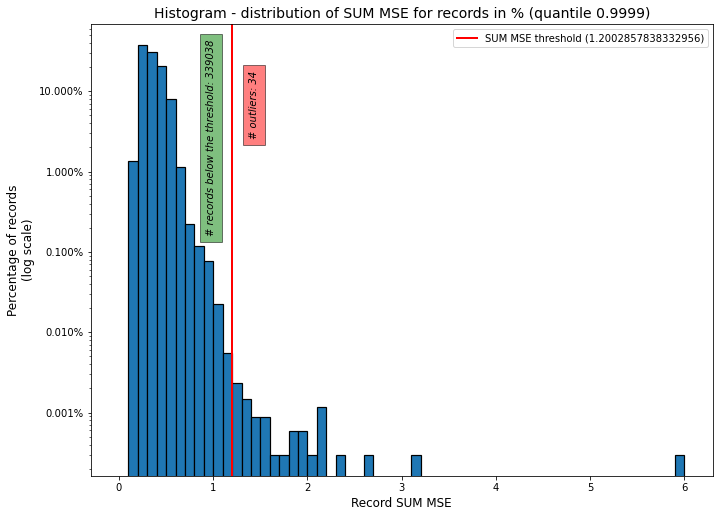

In [149]:
fig, ax = plt.subplots()
file_name = "experiment-1-autoencoder-foods-sum-mse-dist"
sum_mse_data = data_quality_mse_df["sum_mse"]
sum_mse_data.to_csv(f'./images/autoencoder/{file_name}.csv', index_label='id')
sum_mse_threshold = np.quantile(sum_mse_data, method_threshold)
bins_set = np.arange(0.0, max(sum_mse_data) + 0.16, 0.1)

n, bins, patches = ax.hist(sum_mse_data, bins=bins_set,  weights=np.ones(len(sum_mse_data)) / len(sum_mse_data), edgecolor='black', linewidth=1.2)

sum_mse_outliers = data[data["sum_mse"] > sum_mse_threshold]
sum_mse_outliers_len = len(sum_mse_outliers)

sum_mse_ok = data[data["sum_mse"] <= sum_mse_threshold]
sum_mse_ok_len = len(sum_mse_ok)

ax.axvline(sum_mse_threshold, color='r', linewidth=2)
ax.set_xlabel('Record SUM MSE', fontsize=12)
ax.set_ylabel('Percentage of records\n(log scale)', fontsize=12)
ax.text(0.254, 0.75, f'# outliers: {sum_mse_outliers_len}', style='italic', rotation='vertical',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 6}, transform=ax.transAxes)
ax.text(0.185, 0.535, f'# records below the threshold: {sum_mse_ok_len}', style='italic', rotation='vertical',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 6}, transform=ax.transAxes)
ax.set_title("Histogram - distribution of SUM MSE for records in % (quantile {})".format(method_threshold), fontsize=14)
ax.legend(["SUM MSE threshold ({})".format(sum_mse_threshold)], loc='upper right', fontsize=10);

fig.tight_layout()
fig.set_size_inches(15, 13)
plt.yscale('log')
axes = plt.gca()
axes.yaxis.set_major_formatter(PercentFormatter(1, decimals=3))

plt.savefig(f'./images/autoencoder/{file_name}.pdf', bbox_inches='tight')

In [50]:
sum_mse_outliers = data[data["sum_mse"] > sum_mse_threshold]

In [51]:
print(len(sum_mse_outliers))

34


In [52]:
sum_mse_outliers.head()

dq_issue_index orig_data_index           code  \
153              153         1126120  7894900530056   
9751            9751          857939  3770008615007   
20830          20830          692223  3401596716356   
22930          22930         1095397  7613034726087   
25586          25586          732159  3533630086481   

                                                     url  \
153    http://world-en.openfoodfacts.org/product/7894...   
9751   http://world-en.openfoodfacts.org/product/3770...   
20830  http://world-en.openfoodfacts.org/product/3401...   
22930  http://world-en.openfoodfacts.org/product/7613...   
25586  http://world-en.openfoodfacts.org/product/3533...   

                          creator   created_t      created_datetime  \
153                  jcnascimento  1373731939  2013-07-13T16:12:19Z   
9751                      kiliweb  1513900933  2017-12-22T00:02:13Z   
20830                       benny  1425847938  2015-03-08T20:52:18Z   
22930  openfoodfacts-contributors  1416733539  2014-11-23T09:05:39Z   
25586                      tacite  1432552652  2015-05-25T11:17:32Z   

      last_modified_t last_modified_datetime  \
153        1403453251   2014-06-22T16:07:31Z   
9751       1573777576   2019-11-15T00:26:16Z   
20830      1582753039   2020-02-26T21:37:19Z   
22930      1446310232   2015-10-31T16:50:32Z   
25586      1574088461   2019-11-18T14:47:41Z   

                               product_name  \
153    Água Mineral Natural Crystal Sem Gás   
9751          L'œuf qui ne tue pas la poule   
20830                              Relais 2   
22930                      Dès la naissance   
25586                     Baby croissance 3   

                                            generic_name     quantity  \
153                         Água mineral natural sem gás          5 L   
9751                                                Œufs       6 œufs   
20830                                                nan        900 g   
22930  Lait pour nourrissons en poudre de la naissanc...        820 g   
25586    Aliment lacté en poudre pour enfants en bas âge  18 * 13.8 g   

              packaging    packaging_tags  \
153             Garrafa           garrafa   
9751       Boîte,Carton      boite,carton   
20830  Boîte métallique  boite-metallique   
22930       Boîte,Métal       boite,metal   
25586   Carton,dosettes   carton,dosettes   

                                                  brands  \
153    Crystal,Spal Indústria Brasileira de Bebidas,C...   
9751                                          Poulehouse   
20830                                              Picot   
22930                                             guigoz   
25586                                             Candia   

                                             brands_tags  \
153    crystal,spal-industria-brasileira-de-bebidas,c...   
9751                                          poulehouse   
20830                                              picot   
22930                                             guigoz   
25586                                             candia   

                                              categories  \
153          Bebidas, Águas, Spring waters, Água Mineral   
9751               Produits d'élevages, Œufs, Œufs frais   
20830  Aliments pour bébé, Laits pour bébé, Laits 2èm...   
22930  Aliments pour bébé, Laits pour bébé, Laits 1er...   
25586  Aliments pour bébé, Laits pour bébé, Laits de ...   

                                         categories_tags  \
153    en:beverages,en:waters,en:spring-waters,en:min...   
9751           en:farming-products,en:eggs,en:fresh-eggs   
20830  en:baby-foods,en:baby-milks,en:baby-follow-on-...   
22930     en:baby-foods,en:baby-milks,en:infant-formulas   
25586        en:baby-foods,en:baby-milks,en:growth-milks   

                                           categories_en  \
153        Beverages,Waters,Spring waters,Mineral waters   
9751                    Farming products,

In [53]:
sum_mse_outliers

dq_issue_index orig_data_index  \
153               153         1126120   
9751             9751          857939   
20830           20830          692223   
22930           22930         1095397   
25586           25586          732159   
27473           27473          521591   
42793           42793          141407   
44998           44998          628781   
45289           45289          857204   
49058           49058          833537   
61430           61430          533349   
84784           84784          235428   
113251         113251         1259903   
113904         113904          247621   
123927         123927          234729   
135463         135463          830948   
139129         139129          234762   
142005         142005         1095842   
142404         142404          239173   
143091         143091          732158   
149320         149320          234987   
166300         166300          453093   
175676         175676          235432   
199263         199263          830934   
236871         236871         1229581   
239606         239606         1013855   
242570         242570           52167   
275909         275909           42142   
282269         282269          993470   
283054         283054          234967   
287318         287318         1327702   
313007         313007          745242   
313244         313244          489337   
322878         322878         1256173   

                                                 code  \
153                                     7894900530056   
9751                                    3770008615007   
20830                                   3401596716356   
22930                                   7613034726087   
25586                                   3533630086481   
27473                                   3017620429484   
42793                                     60822003016   
44998                                   3270190116912   
45289                                   3770007832108   
49058                                   3760166430123   
61430                                   3046920028363   
84784           0113265479432019200015190630101817101   
113251                                  8436529600292   
113904   02054143392502063103005000171901311020190403   
123927  010360438025953810074303915131109910309000977   
135463                                  3760151013805   
139129     010430652811230717180610310300078239220429   
142005                                  7613035072152   
142404        019542500249234531030003951519061410218   
143091                                  3533630086450   
149320       0109100000000121131810193103000454210529   
166300                                  2227694047168   
175676       0113355710811908108810061520022791000102   
199263                                  3760151012914   
236871                                  8424808112819   
239606                                  5412210007659   
242570                                    29700001476   
275909                                    23923100763   
282269                                  5400113017486   
283054     010843601832698631030100001722042610260419   
287318                                  8801019311345   
313007                                  3560071154714   
313244                                        2558888   
322878                                  8436023660488   

                                                      url  \
153     http://world-en.openfoodfacts.org/product/7894...   
9751    http://world-en.openfoodfacts.org/product/3770...   
20830   http://world-en.openfoodfacts.org/product/3401...   
22930   http://world-en.openfoodfacts.org/product/7613...   
25586   http://world-en.openfoodfacts.org/product/3533...   
27473   http://world-en.openfoodfacts.org/product/3017...   
42793   http://world-en.openfoodfacts.org/product/0060...   
44998   http://world-en.openfoodfacts.org/product/3270...   
45289   http://world-en.op

In [150]:
sum_mse_outliers_synth = data[(data["sum_mse"] > sum_mse_threshold) & (data["has_synthetic_dq_issue"] == '1')]

In [151]:
print(len(sum_mse_outliers_synth))

0


In [152]:
def print_cols(data, index):
    for col_name in data.columns:     
        print("[{}] - {} - {}".format(col_name, type(data.iloc[index][col_name]), data.iloc[index][col_name]))

In [193]:
strange_outlier = sum_mse_outliers[sum_mse_outliers["sum_mse"] > 5.0]

In [194]:
print_cols(strange_outlier, 0)

[dq_issue_index] - <class 'str'> - 142404
[orig_data_index] - <class 'str'> - 239173
[code] - <class 'str'> - 019542500249234531030003951519061410218
[url] - <class 'str'> - http://world-en.openfoodfacts.org/product/019542500249234531030003951519061410218/porchetta-salamone
[creator] - <class 'str'> - verbyy
[created_t] - <class 'str'> - 1558909264
[created_datetime] - <class 'str'> - 2019-05-26T22:21:04Z
[last_modified_t] - <class 'str'> - 1558910074
[last_modified_datetime] - <class 'str'> - 2019-05-26T22:34:34Z
[product_name] - <class 'str'> - Porchetta Salamone
[generic_name] - <class 'str'> - nan
[quantity] - <class 'str'> - 395gr
[packaging] - <class 'str'> - nan
[packaging_tags] - <class 'str'> - nan
[brands] - <class 'str'> - Salamone
[brands_tags] - <class 'str'> - salamone
[categories] - <class 'str'> - Viandes, Porc
[categories_tags] - <class 'str'> - en:meats,en:pork
[categories_en] - <class 'str'> - Meats,Pork
[origins] - <class 'str'> - nan
[origins_tags] - <class 'str'> 

In [153]:
print_cols(sum_mse_outliers, 1)

[dq_issue_index] - <class 'str'> - 9751
[orig_data_index] - <class 'str'> - 857939
[code] - <class 'str'> - 3770008615007
[url] - <class 'str'> - http://world-en.openfoodfacts.org/product/3770008615007/l-oeuf-qui-ne-tue-pas-la-poule-poulehouse
[creator] - <class 'str'> - kiliweb
[created_t] - <class 'str'> - 1513900933
[created_datetime] - <class 'str'> - 2017-12-22T00:02:13Z
[last_modified_t] - <class 'str'> - 1573777576
[last_modified_datetime] - <class 'str'> - 2019-11-15T00:26:16Z
[product_name] - <class 'str'> - L'œuf qui ne tue pas la poule
[generic_name] - <class 'str'> - Œufs
[quantity] - <class 'str'> - 6 œufs
[packaging] - <class 'str'> - Boîte,Carton
[packaging_tags] - <class 'str'> - boite,carton
[brands] - <class 'str'> - Poulehouse
[brands_tags] - <class 'str'> - poulehouse
[categories] - <class 'str'> - Produits d'élevages, Œufs, Œufs frais
[categories_tags] - <class 'str'> - en:farming-products,en:eggs,en:fresh-eggs
[categories_en] - <class 'str'> - Farming products,Egg

In [156]:
print_cols(sum_mse_outliers, 2)

[dq_issue_index] - <class 'str'> - 20830
[orig_data_index] - <class 'str'> - 692223
[code] - <class 'str'> - 3401596716356
[url] - <class 'str'> - http://world-en.openfoodfacts.org/product/3401596716356/relais-2-picot
[creator] - <class 'str'> - benny
[created_t] - <class 'str'> - 1425847938
[created_datetime] - <class 'str'> - 2015-03-08T20:52:18Z
[last_modified_t] - <class 'str'> - 1582753039
[last_modified_datetime] - <class 'str'> - 2020-02-26T21:37:19Z
[product_name] - <class 'str'> - Relais 2
[generic_name] - <class 'str'> - nan
[quantity] - <class 'str'> - 900 g
[packaging] - <class 'str'> - Boîte métallique
[packaging_tags] - <class 'str'> - boite-metallique
[brands] - <class 'str'> - Picot
[brands_tags] - <class 'str'> - picot
[categories] - <class 'str'> - Aliments pour bébé, Laits pour bébé, Laits 2ème âge
[categories_tags] - <class 'str'> - en:baby-foods,en:baby-milks,en:baby-follow-on-milk-from-5-months
[categories_en] - <class 'str'> - Baby foods,Baby milks,Baby follow-on

### Histogram for the column reconstruction errors

In [166]:
clm_mse_outliers_len_dict = {}
step_dict = {}
bins_set_dict = {}
weights_dict = {}
index = 1
for column_name in core_cols:
    print(f"Start: [{column_name}] [{core_cols_count}/{index}]")
    mse_column_name = "{}_mse".format(column_name)
    is_mse_column_name = "is_{}_mse_outlier".format(column_name)
    mse_data = data_quality_mse_df[mse_column_name]
    clm_mse_outliers_len_dict[column_name] = sum(data_quality_mse_df[is_mse_column_name].tolist())
    #step = np.quantile(mse_data, 0.10)
    #step_dict[column_name] = 0.1
    bins_set_dict[column_name] = np.arange(min(mse_data), max(mse_data)+0.015, 0.01)
    weights_dict[column_name] = np.ones(len(mse_data)) / len(mse_data)
    index = index + 1
    print(f"End: [{column_name}]")

Start: [code] [181/1]
End: [code]
Start: [url] [181/2]
End: [url]
Start: [creator] [181/3]
End: [creator]
Start: [created_t] [181/4]
End: [created_t]
Start: [created_datetime] [181/5]
End: [created_datetime]
Start: [last_modified_t] [181/6]
End: [last_modified_t]
Start: [last_modified_datetime] [181/7]
End: [last_modified_datetime]
Start: [product_name] [181/8]
End: [product_name]
Start: [generic_name] [181/9]
End: [generic_name]
Start: [quantity] [181/10]
End: [quantity]
Start: [packaging] [181/11]
End: [packaging]
Start: [packaging_tags] [181/12]
End: [packaging_tags]
Start: [brands] [181/13]
End: [brands]
Start: [brands_tags] [181/14]
End: [brands_tags]
Start: [categories] [181/15]
End: [categories]
Start: [categories_tags] [181/16]
End: [categories_tags]
Start: [categories_en] [181/17]
End: [categories_en]
Start: [origins] [181/18]
End: [origins]
Start: [origins_tags] [181/19]
End: [origins_tags]
Start: [manufacturing_places] [181/20]
End: [manufacturing_places]
Start: [manufacturi

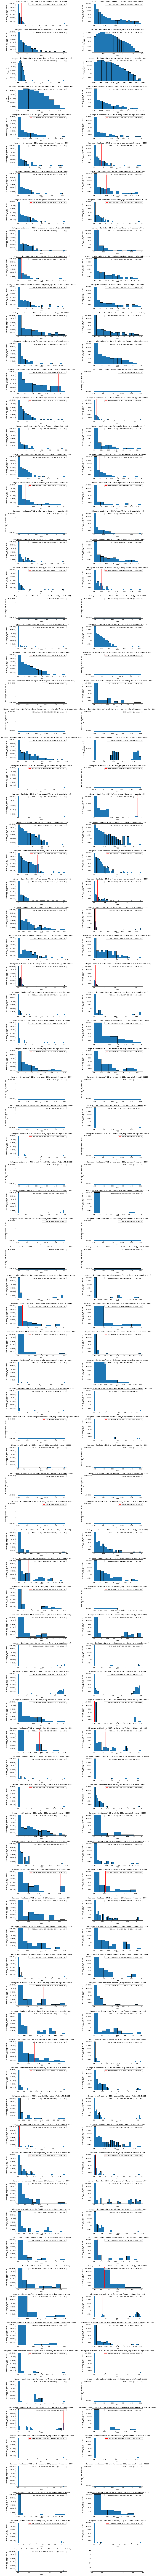

In [167]:
rows_per_column = int(core_cols_count/2) + 1
fig, axs = plt.subplots(rows_per_column, 2)
i = 0
y = 0
index = 0
#print("Plotting")
for column_name in core_cols:
    proc_index = index+1
    #print(f"Start: [{column_name}] [{core_cols_count}/{proc_index}]")
    mse_column_name = "{}_mse".format(column_name)
    is_mse_column_name = "is_{}_mse_outlier".format(column_name)
    mse_data = data_quality_mse_df[mse_column_name]
    column_mse_threshold = mse_threshold_colums[mse_column_name]
    #clm_mse_outliers = data_quality_mse_df[data_quality_mse_df[mse_column_name] > column_mse_threshold]
    clm_mse_outliers_len = clm_mse_outliers_len_dict[column_name]
    bins_set = bins_set_dict[column_name]
    axs[i, y].hist(mse_data, bins=bins_set, weights=weights_dict[column_name], edgecolor='black', linewidth=1)
    axs[i, y].axvline(column_mse_threshold, color='r', linewidth=1)
    axs[i, y].set_xlabel('MSE', fontsize=10)
    #axs[i, y].set_xscale('log')
    axs[i, y].set_ylabel('Percentage of feature records\n(log scale)', fontsize=10)
    axs[i, y].set_title("Histogram - distribution of MSE for '{}' feature in % (quantile {})".format(column_name, method_threshold), fontsize=12)
    axs[i, y].set_yscale('log')
    axs[i, y].yaxis.set_major_formatter(PercentFormatter(1, decimals=3))
    #axs[i, y].margins(0)
    axs[i, y].legend(["MSE threshold ({})(# outliers: {})".format(column_mse_threshold, clm_mse_outliers_len)], loc='upper right', fontsize=10);

    #print(f"End: [{column_name}]")
    # Index process
    y = y + 1    
    if y == 2:
        y = 0
        i = i + 1
    
    if i == rows_per_column:
        i = 0
        
    index = index + 1
        
fig.set_size_inches(18, 300)
fig.tight_layout()
plt.savefig(f'./images/autoencoder/experiment-1-autoencoder-foods-mse-dist-columns.png', bbox_inches='tight')

### Evaluate DQ measurement performance

In [168]:
data_quality_mse_df.head()

code_mse  is_code_mse_outlier   url_mse  is_url_mse_outlier  creator_mse  \
0  0.000500                    0  0.001318                   0     0.000020   
1  0.000419                    0  0.004380                   0     0.000158   
2  0.000734                    0  0.003440                   0     0.002768   
3  0.000476                    0  0.005233                   0     0.000009   
4  0.000815                    0  0.000993                   0     0.000009   

   is_creator_mse_outlier  created_t_mse  is_created_t_mse_outlier  \
0                       0       0.040425                         0   
1                       0       0.064928                         0   
2                       0       0.062412                         0   
3                       0       0.041203                         0   
4                       0       0.053537                         0   

   created_datetime_mse  is_created_datetime_mse_outlier  last_modified_t_mse  \
0              0.022455                                0             0.032292   
1              0.014960                                0             0.027251   
2              0.028228                                0             0.026030   
3              0.026999                                0             0.071759   
4              0.030024                                0             0.062745   

   is_last_modified_t_mse_outlier  last_modified_datetime_mse  \
0                               0                    0.003042   
1                               0                    0.021327   
2                               0                    0.014676   
3                               0                    0.031700   
4                               0                    0.044020   

   is_last_modified_datetime_mse_outlier  product_name_mse  \
0                                      0          0.000002   
1                                      0          0.000002   
2                                      0          0.000002   
3                                      0          0.000002   
4                                      0          0.000002   

   is_product_name_mse_outlier  generic_name_mse  is_generic_name_mse_outlier  \
0                            0      2.662341e-07                            0   
1                            0      2.059147e-04                            0   
2                            0      2.662341e-07                            0   
3                            0      2.662341e-07                            0   
4                            0      2.662341e-07                            0   

   quantity_mse  is_quantity_mse_outlier  packaging_mse  \
0  6.590929e-07                        0   4.721345e-08   
1  1.638040e-06                        0   3.698521e-06   
2  7.970795e-07                        0   9.768614e-08   
3  6.590929e-07                        0   4.721345e-08   
4  6.590929e-07                        0   4.721345e-08   

   is_packaging_mse_outlier  packaging_tags_mse  \
0                         0        4.047686e-07   
1                         0        3.972459e-06   
2                         0        4.314205e-07   
3                         0        4.047686e-07   
4                         0        4.047686e-07   

   is_packaging_tags_mse_outlier    brands_mse  is_brands_mse_outlier  \
0                              0  1.812994e-05                      0   
1                              0  4.608128e-07                      0   
2                              0  5.601539e-07                      0   
3                              0  4.575083e-07                      0   
4                              0  4.717879e-07                      0   

   brands_tags_mse  is_brands_tags_mse_outlier  categories_mse  \
0     2.871377e-05                           0        0.000001   
1     1.961145e-07                           0        0.000224   
2     3.033754e-07                           0        0.000004   
3   

In [169]:
data[data["has_synthetic_dq_issue"] == '1'].head()

dq_issue_index orig_data_index           code  \
305              305          831753  3760155986082   
3390            3390          372446   853158004044   
6469            6469          982183  5099466166301   
8954            8954         1126223  7896004002057   
13390          13390          211503    79893403793   

                                                     url            creator  \
305    http://world-en.openfoodfacts.org/product/3760...            kiliweb   
3390   http://world-en.openfoodfacts.org/product/0853...  org-database-usda   
6469   http://world-en.openfoodfacts.org/product/5099...            kiliweb   
8954   http://world-en.openfoodfacts.org/product/7896...        andre-o-mob   
13390  http://world-en.openfoodfacts.org/product/0079...  org-database-usda   

        created_t         created_datetime last_modified_t  \
305    1587229210     2020-04-18T17:00:10Z      1587229211   
3390   1587655768      2017-07-26T18:27:10      1587655768   
6469   1571326364     2019-10-17T15:32:44Z      1571326366   
8954   1526498159      2017/07/26 18:27:10      1526780740   
13390  1587645361  2019-10-02T11:00:13.155      1587645361   

      last_modified_datetime  \
305     2020-04-18T17:00:11Z   
3390    2020-04-23T15:29:28Z   
6469    2019-10-15T72:21:10Z   
8954    2018-05-20T01:45:40Z   
13390   2020-04-23T12:36:01Z   

                                            product_name  \
305                    Préparation farine façon Tortilla   
3390                            Himalayan minerals water   
6469                                             Butlers   
8954                       Biscoito integral cacau e mel   
13390  Organic blue corn tortilla chips with sesame s...   

                   generic_name quantity packaging packaging_tags     brands  \
305                         nan      nan       nan            nan        nan   
3390                        nan      nan       nan            nan        nan   
6469                        nan      nan       nan            nan        nan   
8954   Biscoito com cacau e mel    120 g   Plastic        plastic  Kellogg's   
13390                       nan      nan       nan            nan        nan   

      brands_tags                                         categories  \
305           nan                                                nan   
3390          nan                                  Beverages, Waters   
6469          nan                                                nan   
8954    kellogg-s  Lanches comida, Lanches doces, Biscoitos e Bol...   
13390         nan                                             Snacks   

                                         categories_tags  \
305                                                  nan   
3390                              en:beverages,en:waters   
6469                                                 nan   
8954   en:snacks,en:sweet-snacks,en:biscuits-and-cake...   
13390                                          en:snacks   

                                         categories_en origins origins_tags  \
305                                                nan     nan          nan   
3390                                  Beverages,Waters     nan          nan   
6469                                               nan     nan          nan   
8954   Snacks,Sweet snacks,Biscuits and cakes,Biscuits     nan          nan   
13390                                           Snacks     nan          nan   

      manufacturing_places manufacturing_places_tags   labels labels_tags  \
305                    nan                       nan      nan         nan   
3390                   nan                       nan      nan         nan   
6469                   nan                       nan      nan         nan   
8954                   nan                       nan      nan         nan   
13390                  nan                       nan  Organic  en:organic   

      labels_en emb_codes emb_codes_tags first_packaging_cod

In [170]:
below_mse_treshold_nonsynthetic_list = []
below_mse_treshold_synthetic_list = []
above_mse_treshold_nonsynthetic_list = [] 
above_mse_treshold_synthetic_list = []
synthetic_issues_count_list = []
unique_values_count_list = []

for column in core_cols:
    below_mse_treshold_nonsynthetic_list.append(len(data_quality_mse_df[(data_quality_mse_df["is_{}_mse_outlier".format(column)] == 0) & (data_quality_mse_df["synthetic_dq_issue_columns"].str.contains(column) == False)]))
    below_mse_treshold_synthetic_list.append(len(data_quality_mse_df[(data_quality_mse_df["is_{}_mse_outlier".format(column)] == 0) & (data_quality_mse_df["synthetic_dq_issue_columns"].str.contains(column) == True)]))
    above_mse_treshold_nonsynthetic_list.append(len(data_quality_mse_df[(data_quality_mse_df["is_{}_mse_outlier".format(column)] == 1) & (data_quality_mse_df["synthetic_dq_issue_columns"].str.contains(column) == False)]))
    above_mse_treshold_synthetic_list.append(len(data_quality_mse_df[(data_quality_mse_df["is_{}_mse_outlier".format(column)] == 1) & (data_quality_mse_df["synthetic_dq_issue_columns"].str.contains(column) == True)]))
    synthetic_issues_count_list.append(len(data_quality_mse_df[(data_quality_mse_df["synthetic_dq_issue_columns"].str.contains(column) == True)]))
    unique_values_count_list.append(len(set(data[column])))

In [171]:
print(below_mse_treshold_nonsynthetic_list)
print(below_mse_treshold_synthetic_list)
print(above_mse_treshold_nonsynthetic_list)
print(above_mse_treshold_synthetic_list)
print(synthetic_issues_count_list)
print(unique_values_count_list)

[339038, 339036, 339040, 339038, 339038, 339038, 339037, 339038, 339038, 339037, 339038, 339038, 339038, 339038, 339038, 339038, 339038, 339038, 339038, 339038, 339039, 339038, 339038, 339038, 339038, 339038, 339048, 339072, 339038, 339038, 339038, 339037, 339038, 339038, 339038, 339038, 339072, 339038, 339038, 339038, 339038, 339041, 339072, 339072, 339063, 339038, 339038, 339072, 339072, 339040, 339064, 339072, 339038, 339072, 339071, 339072, 339058, 339072, 339044, 339069, 339046, 339048, 339037, 339038, 339037, 339038, 339038, 339038, 339038, 339038, 339039, 339038, 339038, 339045, 339038, 339038, 339072, 339072, 339072, 339071, 339068, 339072, 339072, 339072, 339067, 339071, 339072, 339072, 339072, 339072, 339050, 339038, 339038, 339038, 339047, 339041, 339038, 339039, 339067, 339071, 339072, 339066, 339065, 339072, 339072, 339072, 339072, 339072, 339040, 339038, 339038, 339038, 339040, 339052, 339046, 339057, 339068, 339066, 339038, 339072, 339037, 339042, 339041, 339038, 339062,

In [172]:
sum_below_mse_treshold_nonsynthetic_list = sum(below_mse_treshold_nonsynthetic_list)
sum_below_mse_treshold_synthetic_list = sum(below_mse_treshold_synthetic_list)
sum_above_mse_treshold_nonsynthetic_list = sum(above_mse_treshold_nonsynthetic_list)
sum_above_mse_treshold_synthetic_list = sum(above_mse_treshold_synthetic_list)
sum_synthetic_issues_count_list = sum(synthetic_issues_count_list)
sum_unique_values_count_list = sum(unique_values_count_list)

print(sum_below_mse_treshold_nonsynthetic_list)
print(sum_below_mse_treshold_synthetic_list)
print(sum_above_mse_treshold_nonsynthetic_list)
print(sum_above_mse_treshold_synthetic_list)
print(sum_synthetic_issues_count_list)
print(sum_unique_values_count_list)

61367925
9
4091
7
16
3844378


In [173]:
sum_nonsynthetic_records = sum_below_mse_treshold_nonsynthetic_list + sum_above_mse_treshold_nonsynthetic_list
perc_nonsynthetic_issues = (100 / sum_nonsynthetic_records) * sum_above_mse_treshold_nonsynthetic_list
print("Percentage of non-synthetic errors: {}%".format(perc_nonsynthetic_issues))

Percentage of non-synthetic errors: 0.006665904538641846%


In [174]:
# Test: Correctness of data categorization
sum_test_list = [sum(x) for x in zip(below_mse_treshold_nonsynthetic_list, below_mse_treshold_synthetic_list, above_mse_treshold_nonsynthetic_list, above_mse_treshold_synthetic_list)]
right_size = len(data_quality_mse_df)

for test in sum_test_list:
    if right_size != test:
        print("Error!")
    else:
        print("[OK] {} - {}".format(right_size, test))

[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 - 339072
[OK] 339072 -

In [175]:
df = pd.DataFrame({'[non-synthetic] # records below MSE treshold':below_mse_treshold_nonsynthetic_list, '[synthetic] # records below MSE treshold':below_mse_treshold_synthetic_list, '[non-synthetic] # records above MSE treshold':above_mse_treshold_nonsynthetic_list, '[synthetic] # records above MSE treshold':above_mse_treshold_synthetic_list, '# synthetic DQ issues':synthetic_issues_count_list, '# unique values':unique_values_count_list}, index=core_cols)
display(df)

[non-synthetic] # records below MSE treshold  \
code                                                                              339038   
url                                                                               339036   
creator                                                                           339040   
created_t                                                                         339038   
created_datetime                                                                  339038   
last_modified_t                                                                   339038   
last_modified_datetime                                                            339037   
product_name                                                                      339038   
generic_name                                                                      339038   
quantity                                                                          339037   
packaging                                                                         339038   
packaging_tags                                                                    339038   
brands                                                                            339038   
brands_tags                                                                       339038   
categories                                                                        339038   
categories_tags                                                                   339038   
categories_en                                                                     339038   
origins                                                                           339038   
origins_tags                                                                      339038   
manufacturing_places                                                              339038   
manufacturing_places_tags                                                         339039   
labels                                                                            339038   
labels_tags                                                                       339038   
labels_en                                                                         339038   
emb_codes                                                                         339038   
emb_codes_tags                                                                    339038   
first_packaging_code_geo                                                          339048   
cities                                                                            339072   
cities_tags                                                                       339038   
purchase_places                                                                   339038   
stores                                                                            339038   
countries                                                                         339037   
countries_tags                                                                    339038   
countries_en                                                                      339038   
ingredients_text                                                                  339038   
allergens                                                                         339038   
allergens_en                                                                      339072   
traces                                                                            339038   
traces_tags                                                                       339038   
traces_en                                                                         339038   
serving_size                                                                      339038   
serving_quantity                                                                  339041   
no_nutriments                                                                     339072

In [176]:
df.to_latex('./latex/autoencoder/experiment-1-autoencoder-foods_mse_summary_results.tex')

In [177]:
df.to_csv('./latex/autoencoder/experiment-1-autoencoder-foods_mse_summary_results.csv', index_label="column name")

## Evaluate success of the autoencoder model on synthetic errors

In [178]:
synthetic_issues_count = sum(synthetic_issues_count_list)
above_mse_treshold_synthetic_count = sum(above_mse_treshold_synthetic_list)
success = (100/synthetic_issues_count)*above_mse_treshold_synthetic_count
print("Success of the model in synthetic errors: {}%".format(success))

Success of the model in synthetic errors: 43.75%


## Examining the results

In [179]:
data[data["has_synthetic_dq_issue"] == '1']

dq_issue_index orig_data_index              code  \
305               305          831753     3760155986082   
3390             3390          372446      853158004044   
6469             6469          982183     5099466166301   
8954             8954         1126223     7896004002057   
13390           13390          211503       79893403793   
16169           16169          111780       42400109334   
31169           31169         1097518     7613036039468   
151999         151999          153666       70272491233   
311000         311000           64534       35826088352   
319072         319072         1172663  841-010-000-2002   

                                                      url  \
305     http://world-en.openfoodfacts.org/product/3760...   
3390    http://world-en.openfoodfacts.org/product/0853...   
6469    http://world-en.openfoodfacts.org/product/5099...   
8954    http://world-en.openfoodfacts.org/product/7896...   
13390   http://world-en.openfoodfacts.org/product/0079...   
16169   http://world-en.openfoodfacts.org/product/0042...   
31169   http://world-en.openfoodfacts.org/product/7613...   
151999  http://world-en.openfoodfacts.org/product/0070...   
311000  http://world-en.openfoodfacts.org/product/0035...   
319072  http://world-en.payfoodfacts.org/product/84101...   

                           creator   created_t         created_datetime  \
305                        kiliweb  1587229210     2020-04-18T17:00:10Z   
3390             org-database-usda  1587655768      2017-07-26T18:27:10   
6469                       kiliweb  1571326364     2019-10-17T15:32:44Z   
8954                   andre-o-mob  1526498159      2017/07/26 18:27:10   
13390            org-database-usda  1587645361  2019-10-02T11:00:13.155   
16169            org-database-usda  1587654833     2020-04-23T15:13:53Z   
31169                    carlahask  1546422587     2019-01-02T09:49:47Z   
151999           org-database-usda  1587583723     2020-04-22T19:28:43Z   
311000             usda-ndb-import  1489071406     2017-03-09T14:56:46Z   
319072  openfoodfacts-contributors  1460331867     2016-04-10T23:44:27Z   

       last_modified_t last_modified_datetime  \
305         1587229211   2020-04-18T17:00:11Z   
3390        1587655768   2020-04-23T15:29:28Z   
6469        1571326366   2019-10-15T72:21:10Z   
8954        1526780740   2018-05-20T01:45:40Z   
13390       1587645361   2020-04-23T12:36:01Z   
16169       1587654834   2020-04-23T15:13:54Z   
31169       1578086950   2020-01-03T21:29:10Z   
151999      1587583723   2020-04-22T19:28:43Z   
311000      1587584825   2020-04-22T19:47:05Z   
319072      1552904761   2019-03-18T10:26:01Z   

                                             product_name  \
305                     Préparation farine façon Tortilla   
3390                             Himalayan minerals water   
6469                                              Butlers   
8954                        Biscoito integral cacau e mel   
13390   Organic blue corn tortilla chips with sesame s...   
16169                                              Cereal   
31169                                                Café   
151999            Non-Dairy Whipped Topping, 15 oz, 15 OZ   
311000                  Food lion, pecan pleasers cookies   
319072                                              Toque   

                         generic_name quantity      packaging packaging_tags  \
305                               nan      nan            nan            nan   
3390                              nan      nan            nan            nan   
6469                              nan      nan            nan            nan   
8954         Biscoito com cacau e mel    120 g        Plastic        plastic   
13390                             nan      nan            nan            nan   
16169                             nan      nan            nan            nan   
31169   Café molido de tueste natural    500 g    Bolsa,Papel    bolsa,papel   
151999 

In [180]:
print(min(data["fiber_100g"].astype(float)))
print(data["fiber_100g"].astype(float).nlargest(2))

-6.7
311000    1562.3
59139      439.0
Name: fiber_100g, dtype: float64


In [181]:
column = "fiber_100g"
available_size_issues = data[data["outlier_columns"].str.contains(column) == True]  
if len(available_size_issues) > 0:
    print("---- '{}' ----".format(column))
    print(*available_size_issues[column].tolist(), sep='\n')

---- 'fiber_100g' ----
22.2
10.9
15.4
26.7
23.2
4.44444444444444
1.0
11.6
10.0
12.0
22.9
1.39999997615814
14.8936170212766
15.3
40.0
9.910101
12.1
38.9
32.0
15.0
10.8
12.1
4.28571428571428
5e-05
7.5
17.5
13.3
1.48148148148148
12.5
11.1
2.35294117647059
1.1764705882353
2.7027027027027
0.555556
20.0
12.0
10.4
10.8
37.8
1.42857142857143
9.80000019073485
2.85714285714285
31.4
0.00151
16.7
30.0
3.33333
1.29999995231629
9.23077
10.0
0.006999999999999999
11.1
30.0
22.3
15.1
1.93236714975846
3.18182
22.2
23.2
17.5
15.0
12.1
15.1
20.0
23.2
2.38095238095238
50.0
22.2
10.6
14.5
14.8
10.8695652173913
0.011000000000000001
6.66667
10.0
13.3
7.89474
0.8130081300813
1.53846153846154
10.5
0.0033299999999999996
24.3
43.3
10.3
7.09999990463255
22.9
22.2
9.41176470588235
12.1
34.5239
11.4
0.006999999999999999
1.53846153846154


In [182]:
for column in core_cols:
    available_size_issues = data[data["outlier_columns"].str.contains(column) == True]  
    if len(available_size_issues) > 0:
        print("---- '{}' ----".format(column))
        print(*available_size_issues[column].tolist(), sep='\n')

---- 'code' ----
8437008529509
3499604250084
280
01080051100600211522083110222
8017977004414
3596710016563
26
3596710207817
68
8425779043287
79
3228022120101
44695082002
8436013830020
8480000165619
8437010207815
91
3268260006058
3270160403172
8410128670238
26067926
01
8410297161728
8414555004000
3228021140117
8410376040692
3271820004449
8431876105971
8433329035637
30
8437001670161
72
43
8410199380418
29
130
3270160890842
001
3560070657391
3000121146103
2461371026309
010360438025953810074303915131109910309000977
3228023130192
20021078
00065099831333333050022009080000241000009908505500036500880
2461312043754
3222472183167
8480017038685
8437000270508
8480000331861
3523230050524
52
8410000005387
20501303
8421691846289
90
3263859362218
8480000167767
8410426350054
20379841
8421691788282
048
3308650396885
258
8410066120888
024
20477301
8424259826051
3248833085130
04
8480000330536
8410261611181
63
011
3258561464015
20243371
22
77
8436013830112
34
212
24041102
8436535010153
118
8480024742025
84

In [183]:
packaging_count = len(data["packaging"])
print(packaging_count)
packaging_nan_count = len(data[data["packaging"] == "nan"])
print(packaging_nan_count)
packaging_unique_count = len(set(data["packaging"]))
print(packaging_unique_count)

339072
285686
12989


In [184]:
packaging_count = len(data["allergens_en"])
print(packaging_count)
packaging_nan_count = len(data[data["allergens_en"] == "nan"])
print(packaging_nan_count)
packaging_unique_count = len(set(data["allergens_en"]))
print(packaging_unique_count)

339072
339072
1


In [185]:
set(data["nutriscore_grade"])

{'9', 'a', 'b', 'c', 'd', 'e', 'nan'}